# Validate and test ROC/AUC scoring
Based on built-in scikit-learn dataset (breast cancer classification)

\>> Simplified version which only considers one choice for hyperparameter

In [61]:
from __future__ import division
import numpy as np
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve, auc
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt

In [62]:
np.__version__

'1.14.5'

### Two different ways of scoring: `roc_auc` and `make_scorer(roc_auc_score)`

Can demonstrate different results via different methods

This is done below by showing different scores for C=10. But in fact when searching over C=[9.9, 10, 10.1], it turns out that different parameters are returned by the two different methods.

In [63]:
X, y = load_breast_cancer(return_X_y=True)

In [64]:
X.__class__, y.__class__

(numpy.ndarray, numpy.ndarray)

Use built in `roc_auc` option:

In [65]:
gs1 = GridSearchCV(LogisticRegression(random_state=np.random.RandomState(0)),
                   {'C': [10]},
                   cv=StratifiedKFold(3, random_state=np.random.RandomState(1), shuffle=True),
                   scoring='roc_auc')
fit1 = gs1.fit(X, y)

print('Best param: ' + str(fit1.best_params_))
print('Best score: ' + str(fit1.best_score_))

Best param: {'C': 10}
Best score: 0.992004586185572


Use `make_scorer(roc_auc_score)`:

In [66]:
gs2 = GridSearchCV(LogisticRegression(random_state=np.random.RandomState(0)),
                   {'C': [10]},
                   cv=StratifiedKFold(3, random_state=np.random.RandomState(1), shuffle=True),
                   scoring=make_scorer(roc_auc_score))
fit2 = gs2.fit(X, y)

print('Best param: ' + str(fit2.best_params_))
print('Best score: ' + str(fit2.best_score_))

Best param: {'C': 10}
Best score: 0.9563072740173076


Check that it is not a random state issue, i.e. that we can recreate an above score exactly:

In [67]:
gs3 = GridSearchCV(LogisticRegression(random_state=np.random.RandomState(0)),
                   {'C': [10]},
                   cv=StratifiedKFold(3, random_state=np.random.RandomState(1), shuffle=True),
                   scoring='roc_auc')
fit3 = gs3.fit(X, y)

print('Best param: ' + str(fit3.best_params_))
print('Best score: ' + str(fit3.best_score_))

Best param: {'C': 10}
Best score: 0.992004586185572


### Next work it through manually
Extract the CV folds and fit logistic regressions manually

In [68]:
logregA = LogisticRegression(random_state=np.random.RandomState(0), C=10)

In [69]:
cv_man = StratifiedKFold(3, random_state=np.random.RandomState(1), shuffle=True)
cv_man_split = cv_man.split(X, y)

In [70]:
results_imported_score_preds = []
results_imported_score_predprobs = []
results_imported_score_predprobs_inverse = []

#### This bit repeats per fold:

In [71]:
indices1 = cv_man_split.next()
len(indices1[0]), len(indices1[1])

(379, 190)

In [72]:
## Fit to train split and predict on test split
fit_man1 = logregA.fit(X=X[indices1[0], :], y=y[indices1[0]])
pred_man1 = fit_man1.predict(X[indices1[1], :])
pred_prob_man1 = fit_man1.predict_proba(X[indices1[1], :])
true_man1 = y[indices1[1]]

In [73]:
results_imported_score_preds.append(roc_auc_score(true_man1, pred_man1))
results_imported_score_predprobs.append(roc_auc_score(true_man1, pred_prob_man1[:, 1]))
results_imported_score_predprobs_inverse.append(roc_auc_score(1 - true_man1, pred_prob_man1[:, 0]))

In [74]:
print(results_imported_score_preds)
print(results_imported_score_predprobs)

[0.9466209018818794]
[0.9872174221801397]


Again:

In [75]:
indices2 = cv_man_split.next()
fit_man2 = logregA.fit(X=X[indices2[0], :], y=y[indices2[0]])

pred_man2 = fit_man2.predict(X[indices2[1], :])
pred_prob_man2 = fit_man2.predict_proba(X[indices2[1], :])
true_man2 = y[indices2[1]]

results_imported_score_preds.append(roc_auc_score(true_man2, pred_man2))
results_imported_score_predprobs.append(roc_auc_score(true_man2, pred_prob_man2[:, 1]))
results_imported_score_predprobs_inverse.append(roc_auc_score(1 - true_man2, pred_prob_man2[:, 0]))

And again:

In [76]:
indices3 = cv_man_split.next()
fit_man3 = logregA.fit(X=X[indices3[0], :], y=y[indices3[0]])

pred_man3 = fit_man3.predict(X[indices3[1], :])
pred_prob_man3 = fit_man3.predict_proba(X[indices3[1], :])
true_man3 = y[indices3[1]]

results_imported_score_preds.append(roc_auc_score(true_man3, pred_man3))
results_imported_score_predprobs.append(roc_auc_score(true_man3, pred_prob_man3[:, 1]))
results_imported_score_predprobs_inverse.append(roc_auc_score(1 - true_man3, pred_prob_man3[:, 0]))

In [77]:
print(results_imported_score_preds)
print(results_imported_score_predprobs)
print(results_imported_score_predprobs_inverse)

[0.9466209018818794, 0.9563853710498285, 0.965966386554622]
[0.9872174221801397, 0.9928985678778554, 0.9959183673469387]
[0.9872174221801396, 0.9928985678778554, 0.9959183673469387]


In [78]:
print(sum(results_imported_score_preds)/len(results_imported_score_preds))
print(fit2.best_score_)

0.9563242198287766
0.9563072740173076


In [79]:
print(sum(results_imported_score_predprobs)/len(results_imported_score_predprobs))
print(fit1.best_score_)

0.9920114524683113
0.992004586185572


We are a few decimal places out - but otherwise presumably match?
### Make some ROC plots

In [80]:
true_man = np.append(np.append(true_man1, true_man2), true_man3)
pred_man = np.append(np.append(pred_man1, pred_man2), pred_man3)
pred_prob_man = np.append(np.append(pred_prob_man1, pred_prob_man2, axis=0), pred_prob_man3, axis=0)

First using the probabilities:

In [81]:
fpr1, tpr1, threshold1 = roc_curve(true_man, pred_prob_man[:, 1])
auc1 = auc(fpr1, tpr1)

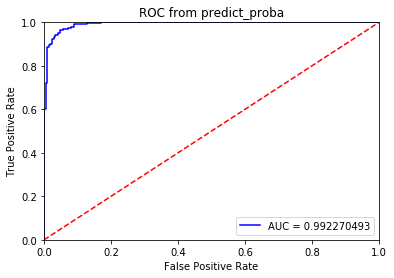

In [82]:
plt.title('ROC from predict_proba')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.9f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Now using the predictions directly:

In [83]:
fpr2, tpr2, threshold2 = roc_curve(true_man, pred_man)
auc2 = auc(fpr2, tpr2)

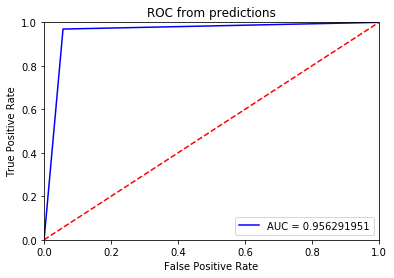

In [84]:
plt.title('ROC from predictions')
plt.plot(fpr2, tpr2, 'b', label = 'AUC = %0.9f' % auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Conclusion

Do not use `make_scorer(roc_auc_score)` as this will default to incorrectly use the predicted classes.

Actually it turns out that the `make_scorer()` function can be employed in this situation by enabling the `needs_threshold` argument:

In [85]:
gs4 = GridSearchCV(LogisticRegression(random_state=np.random.RandomState(0)),
                   {'C': [10]},
                   cv=StratifiedKFold(3, random_state=np.random.RandomState(1), shuffle=True),
                   scoring=make_scorer(roc_auc_score, needs_threshold=True))
fit4 = gs4.fit(X, y)

print('Best param: ' + str(fit4.best_params_))
print('Best score: ' + str(fit4.best_score_))

Best param: {'C': 10}
Best score: 0.992004586185572
